In [26]:
import numpy as np
import os, sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
import re
import concurrent.futures
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from collections import OrderedDict
import copy
import pickle
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cloudpickle
import ast
from contextlib import contextmanager

from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import get_column_plot

import dask.dataframe as dpd
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [86]:
import gc
gc.collect()

0

In [89]:
client = Client(n_workers=100) #128 totally

In [88]:
client.close()

# Coord

In [29]:
coord_gdf = gpd.read_file('../src/coord/coord_gdf.shp')
coord_gdf = coord_gdf.drop(columns=['cell_rmse1', 'cell_r21', 'cell_rmse2', 'cell_r22', 'depth'])

In [30]:
coord_gdf

,x,y,ter,HUC12,region,channel,geometry
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"POLYGON ((3038721.900 13851266.014, 3038723.76..."


In [31]:
coord_union_gdf = gpd.GeoDataFrame(geometry=[coord_gdf.unary_union], crs=coord_gdf.crs)

# Generated events

In [32]:
syn_events_df = pd.read_parquet('../outputs/aggregated_syn_events.parquet')

In [33]:
syn_events_df

,x,y,cumu_rain,peak_int,duration,channel,ter,syn_depth
0,3.122392e+06,1.394752e+07,3.713448,3.316965,5,0,90.984207,1.872441
1,3.068903e+06,1.393315e+07,4.668564,3.269290,2,0,106.370415,1.857054
2,3.033544e+06,1.394389e+07,1.984802,1.585991,14,0,164.404495,1.634104
3,3.033464e+06,1.393909e+07,0.941279,0.395483,5,0,157.055893,1.599063
4,3.000083e+06,1.393516e+07,5.070308,2.681067,6,0,174.948807,1.718153
...,...,...,...,...,...,...,...,...
1336615,3.066836e+06,1.390885e+07,1.219238,0.769866,4,1,100.226967,1.071834
1336616,3.164059e+06,1.391041e+07,3.903505,0.698521,6,1,40.256813,1.499436
1336617,3.092509e+06,1.386748e+07,7.844639,2.103962,5,1,38.867851,1.827506
1336618,3.084451e+06,1.390820e+07,2.645236,0.734870,9,1,84.812500,1.152786


# Aggregate events into coord_gdf

In [34]:
coord_dgdf = dgpd.from_geopandas(coord_gdf, npartitions=10)[['channel', 'ter', 'geometry']]
syn_events_gdf = gpd.GeoDataFrame(syn_events_df, geometry=gpd.points_from_xy(syn_events_df['x'], syn_events_df['y']), crs=coord_gdf.crs)
syn_events_dgdf = dgpd.from_geopandas(syn_events_gdf, npartitions=200)[['cumu_rain', 'peak_int', 'duration', 'syn_depth', 'geometry']]
syn_events_w_cell_gdf = syn_events_dgdf.sjoin(coord_dgdf, predicate='within').compute()

In [35]:
syn_events_w_cell_gdf

,cumu_rain,peak_int,duration,syn_depth,geometry,index_right,channel,ter
0,3.713448,3.316965,5,1.872441,POINT (3122392.090 13947521.928),693,0,90.984207
1,4.668564,3.269290,2,1.857054,POINT (3068902.846 13933147.302),2194,0,106.370415
2,1.984802,1.585991,14,1.634104,POINT (3033544.231 13943885.726),1116,0,164.404495
3,0.941279,0.395483,5,1.599063,POINT (3033464.060 13939088.377),1486,0,157.055893
4,5.070308,2.681067,6,1.718153,POINT (3000083.494 13935157.633),2010,0,174.948807
...,...,...,...,...,...,...,...,...
1336614,0.000000,0.000000,16,1.003747,POINT (3007589.559 13839269.556),23703,1,87.031250
1336615,1.219238,0.769866,4,1.071834,POINT (3066836.304 13908854.476),24145,1,100.226967
1336616,3.903505,0.698521,6,1.499436,POINT (3164058.607 13910412.494),24425,1,40.256813
1336618,2.645236,0.734870,9,1.152786,POINT (3084451.493 13908204.598),24163,1,84.812500


In [36]:
syn_events_w_cell_ddf = dpd.from_pandas(syn_events_w_cell_gdf, npartitions=200)
coord_gdf_ddf = dpd.from_pandas(coord_gdf, npartitions=10)
aggregated_df = syn_events_w_cell_ddf.groupby('index_right').agg({
    'cumu_rain': list,
    'peak_int': list,
    'duration': list,
    'syn_depth': list
}).compute()
aggregated_df.columns = [f'{col}_list' for col in aggregated_df.columns if col != 'index_right']
aggregated_df = aggregated_df.reset_index()

coord_gdf_w_distributions = coord_gdf.reset_index().merge(aggregated_df, left_on='index', right_on='index_right', how='left').drop(columns=['index', 'index_right'])

In [37]:
empty_cell_indices = coord_gdf_w_distributions[coord_gdf_w_distributions['duration_list'].isna()].index

In [38]:
coord_gdf_w_distributions.loc[empty_cell_indices, ['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']] = ['[]', '[]', '[]', '[]']

In [39]:
coord_gdf_w_distributions[['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']] = coord_gdf_w_distributions[['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']].astype(str)

In [40]:
coord_gdf_w_distributions.drop(columns=['geometry']).to_parquet('../outputs/coord_w_syn_distributions.parquet')

# Get real events distribution

In [90]:
np.random.seed(0)
sample_event_num = 50
event_indices = np.random.choice(range(593), sample_event_num, replace=False)
event_indices


array([240, 132, 571,  92, 170, 449, 573, 471, 187, 229, 181, 239, 587,
       390, 438, 402, 590, 142, 246, 378, 394,  85, 196, 173, 367, 278,
       178,   1, 334, 517,  14, 222, 584, 103, 426, 351,   8, 585, 213,
       320,  21, 379, 118, 250, 282, 516, 557,  48,  52, 336])

In [102]:
scaler = MinMaxScaler()
xy_scaled = scaler.fit_transform(coord_gdf[['x', 'y']])

def load_and_scale(file_path, scale=False):
    df = pd.read_parquet(file_path)[['x', 'y', 'channel', 'ter', 'cumu_rain', 'peak_int', 'duration', 'depth']].reset_index()
    if scale:
        df[['x', 'y']] = xy_scaled
    return df
file_paths = [f'../src/tables/data{i}.parquet' for i in event_indices]
selected_events = [load_and_scale(file) for file in file_paths]
with ProgressBar():
    result = dpd.concat(selected_events, axis=0)
selected_events_df = result.compute()
selected_events_df = selected_events_df.drop(columns=['channel', 'ter', 'depth']).reset_index(drop=True)

In [106]:
selected_events_df

,index,x,y,cumu_rain,peak_int,duration
0,0,2.933766e+06,1.396557e+07,0.330646,0.330646,2
1,1,2.934966e+06,1.396557e+07,0.331812,0.331812,2
2,2,2.933766e+06,1.396437e+07,0.321467,0.311706,2
3,3,2.934966e+06,1.396437e+07,0.319289,0.310321,2
4,4,2.936166e+06,1.396437e+07,0.317112,0.308937,2
...,...,...,...,...,...,...
1315045,26296,3.039069e+06,1.385008e+07,0.618965,0.618965,1
1315046,26297,3.039053e+06,1.385088e+07,0.672483,0.672483,1
1315047,26298,3.038396e+06,1.385006e+07,0.642401,0.642401,1
1315048,26299,3.038392e+06,1.385087e+07,0.681234,0.681234,1


In [107]:
selected_events_ddf = dpd.from_pandas(selected_events_df, npartitions=100)

In [119]:
real_aggregated_df = selected_events_ddf[['index', 'cumu_rain', 'peak_int', 'duration']].groupby('index').agg({
    'cumu_rain': list,
    'peak_int': list,
    'duration': list
}).compute()

In [120]:
real_aggregated_df = real_aggregated_df.reset_index().sort_values('index')
real_aggregated_df.columns = [col if col == 'index' else f'{col}_list' for col in real_aggregated_df.columns]

In [122]:
coord_gdf['cumu_rain_list'] = real_aggregated_df['cumu_rain_list']
coord_gdf['peak_int_list'] = real_aggregated_df['peak_int_list']
coord_gdf['duration_list'] = real_aggregated_df['duration_list']

In [123]:
coord_gdf

,x,y,ter,HUC12,region,channel,geometry,cumu_rain_list,peak_int_list,duration_list
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2933003.17...","[0.33064562687238325, 3.4353019397236944, 3.45...","[0.33064562687238325, 2.0274635405143604, 1.85...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"POLYGON ((2934366.000 13967369.160, 2934380.33...","[0.33181169233243324, 3.5655307458970036, 3.51...","[0.33181169233243324, 2.0369607281845283, 1.89...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2934366.00...","[0.3214672151337218, 3.2914149397798367, 3.565...","[0.3117059725682517, 1.9273465598215749, 1.925...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,"POLYGON ((2935566.000 13963774.635, 2934366.00...","[0.3192894373181301, 3.4363269453642724, 3.611...","[0.3103212984168354, 1.9427784745768615, 1.954...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"POLYGON ((2936766.000 13963774.635, 2935566.00...","[0.3171116537581268, 3.581238876783847, 3.6581...","[0.3089366188200968, 1.9582103508892832, 1.983...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"POLYGON ((3039427.707 13849492.726, 3038745.86...","[0.48749239273425715, 4.111612884896381, 3.906...","[0.48749239273425715, 2.5305863431648348, 2.83...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"POLYGON ((3039399.212 13851153.541, 3039405.50...","[0.475346273398884, 4.063332796912746, 3.96403...","[0.475346273398884, 2.485630294188475, 2.90337...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"POLYGON ((3038723.769 13850469.724, 3038724.68...","[0.572674283161176, 4.024786644238761, 3.79792...","[0.572674283161176, 2.494351202299491, 2.72791...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"POLYGON ((3038721.900 13851266.014, 3038723.76...","[0.5628447839842705, 3.9644412596905383, 3.889...","[0.5628447839842705, 2.4372635605025863, 2.828...","[2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,..."


# Cluster events

In [41]:
coord_gdf_w_distributions = gpd.GeoDataFrame(pd.read_parquet('../outputs/coord_w_syn_distributions.parquet'), geometry=coord_gdf['geometry'], crs=coord_gdf.crs)

# trans list str to list
distri_lists = ['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']
coord_gdf_w_distributions[distri_lists] = coord_gdf_w_distributions[distri_lists].applymap(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

In [42]:
coord_gdf_w_distributions

,x,y,ter,HUC12,region,channel,cumu_rain_list,peak_int_list,duration_list,syn_depth_list,geometry
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"[4.261717701692649, 1.4959194253012689, 2.7302...","[3.904449482084619, 0.77255816395237, 0.923203...","[14, 9, 7, 14, 5, 14]","[1.3894822597503662, 1.037487268447876, 1.0532...","POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"[7.7209288347970855, 5.104717655341985, 2.1935...","[2.521824258852379, 3.154637289548779, 0.44817...","[5, 14, 14, 14, 16]","[1.6728062629699707, 1.1284449100494385, 1.071...","POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"[1.0755354109375177, 12.793700590715742, 1.412...","[0.16023271095298985, 3.305349168738996, 0.508...","[7, 5, 6, 14]","[1.0152256488800049, 1.2384905815124512, 1.025...","POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"[4.612446325787333, 4.570429519923819, 9.99994...","[3.886058443499909, 2.8371771383846136, 2.7812...","[7, 5, 9, 9, 7, 16, 3, 7, 14, 14, 14, 5, 14, 4...","[1.8712635040283203, 1.6643896102905273, 1.871...","POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"[14.642544322390133, 0.661175148861201, 1.6781...","[5.100393193150091, 0.3412274503517189, 0.8149...","[6, 5, 7, 7, 4, 9, 9, 3, 4, 7, 7, 5, 7, 6, 14,...","[1.9932854175567627, 1.193894624710083, 1.3923...","POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"[3.298841396328916, 10.956957771228982, 2.6570...","[1.4450330284737454, 4.251772916385593, 0.4532...","[9, 14, 14, 16, 14, 7, 14, 7, 5, 5, 4, 6, 5, 4...","[1.3853836059570312, 1.890486478805542, 1.3101...","POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"[5.856349491341058, 3.751165660160963, 0.89703...","[3.4011183771993405, 2.2037224915302334, 0.379...","[4, 7, 14, 9, 4, 9, 6, 14, 7, 14, 6, 4, 14, 16...","[1.687591314315796, 1.531592607498169, 1.17666...","POLYGON ((3038721.900 13851266.014, 3038723.76..."


In [176]:
def plot_cell_distri(df, cell_index, col, bins=25, sep=True, real=True):
    col_list = df.loc[cell_index, f'{col}_list']
    mean = np.mean(col_list)
    std = np.std(col_list)
    
    # Separate data into three categories
    less_than_mean_minus_std = [x for x in col_list if x <= mean - 0.25*std]
    between_mean_std = [x for x in col_list if mean - 0.25*std < x <= mean + std]
    greater_than_mean_plus_std = [x for x in col_list if x > mean + std]
    
    if sep:
    # Plot each category with different colors
        plt.hist(less_than_mean_minus_std, bins=bins, density=True, alpha=0.5, color='blue', label='Low')
        plt.hist(between_mean_std, bins=bins, density=True, alpha=0.5, color='green', label='Medium')
        plt.hist(greater_than_mean_plus_std, bins=bins, density=True, alpha=0.5, color='red', label='High')
        plt.legend()
    else:
        plt.hist(col_list, density=True, bins=bins)
    
    plt.xlim([0, 30 if col!='duration' else 20])
    plt.title(f'Distribution of cell {cell_index} {"real" if real else "synthetic"} {col}')
    plt.show()

    print(np.mean(col_list), np.std(col_list))

In [162]:
cell_idx = 10000

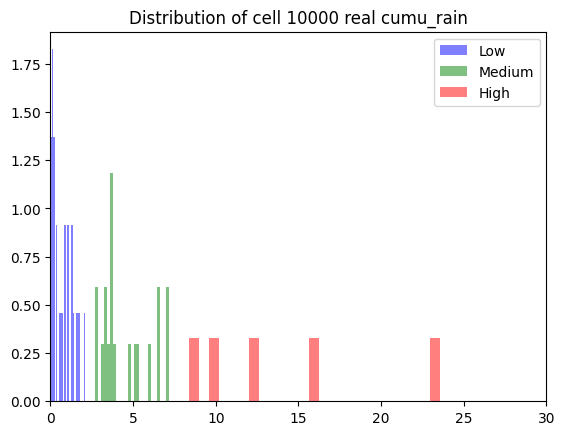

3.49822553859434 4.4126725878585695


In [167]:
plot_cell_distri(coord_gdf, cell_idx, 'cumu_rain')

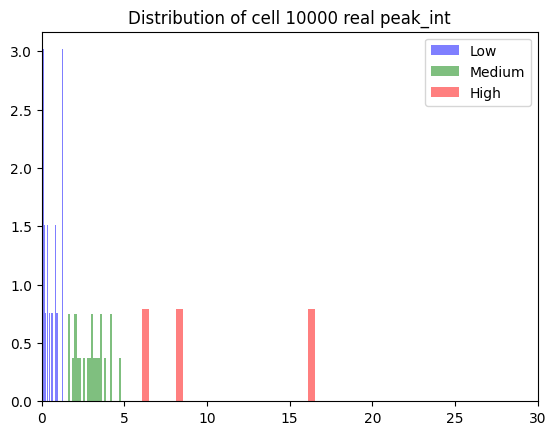

2.150269750714983 2.7018058703502477


In [168]:
plot_cell_distri(coord_gdf, cell_idx, 'peak_int')

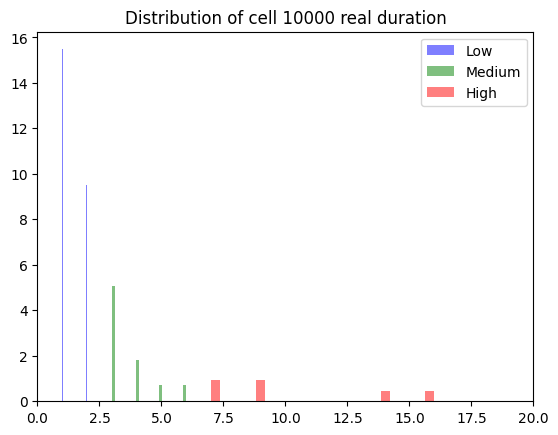

3.5 3.0740852297878796


In [169]:
c

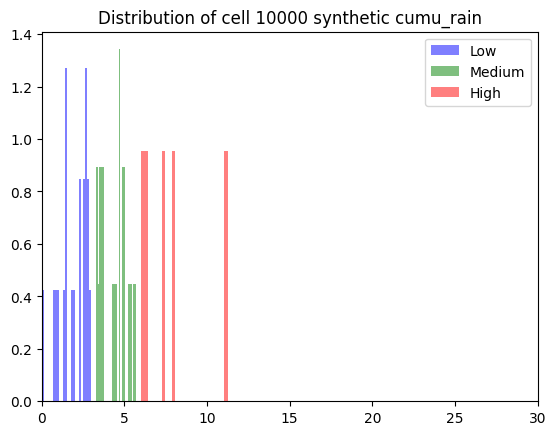

3.7144876084838603 2.054233703262075


In [177]:
plot_cell_distri(coord_gdf_w_distributions, cell_idx, 'cumu_rain', real=False)

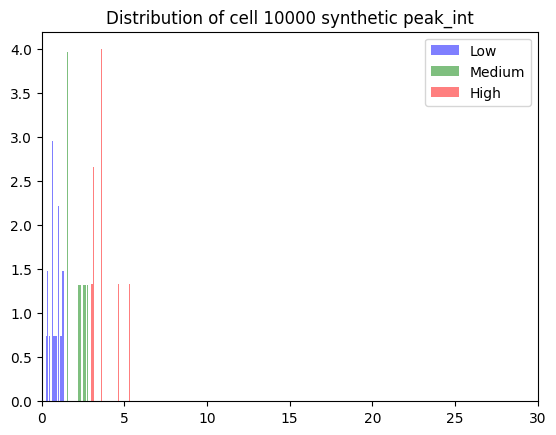

1.760019971900105 1.1880313246780674


In [178]:
plot_cell_distri(coord_gdf_w_distributions, cell_idx, 'peak_int', real=False)

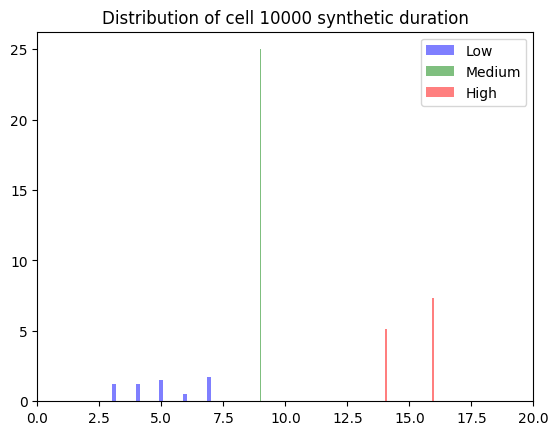

9.125 4.811552937115695


In [179]:
plot_cell_distri(coord_gdf_w_distributions, cell_idx, 'duration', real=False)